# 🚀 Spaceship Titanic Project (2) - Raquel G Vernet

Hi! 👋 This notebook is part of my personal data science portfolio.  

The goal is to analyze the **Spaceship Titanic** dataset from Kaggle and build a predictive model to determine whether passengers were transported to another dimension.  

This is **Part 2: Modeling**.  
All exploratory data analysis, imputation, and feature engineering were performed in the previous notebook:  
*1) Spaceship Titanic - EDA, Imputation and Feature Engineering*.  
Here, the dataset is already clean, imputed, and feature-engineered, ready for predictive modeling.  

Tree-based models (Random Forest, XGBoost) are chosen because they handle categorical variables well with **ordinal encoding** and are robust to non-linear feature interactions.  

---

## Main Steps  

**1. Random Forest**  
- Train and tune Random Forest models (GridSearch).  
- Evaluate performance (Accuracy, F1-score, ROC-AUC, confusion matrix).  
- Feature importance

**2. XGBoost**  
- Train and tune XGBoost models (GridSearch).  
- Evaluate using the same metrics.  
- Feature importance

**3. Ensemble**  
- Combine models using Voting or Stacking.  
- Compare ensemble vs single models.  
- Analyze feature importance across models.  

**4. Final Model & Predictions**  
- Compare all models in a summary table.  
- Select the best model and retrain on the full dataset.  
- Generate predictions for the test dataset.  

**5. 📌 Conclusions**  
- Summarize model performance, key features, and lessons learned.  

## 0. Data Loading & Train/Test Split

In [1]:
import pandas as pd 

Train_Space = pd.read_csv('processed_train.csv')
Test_Space = pd.read_csv('processed_test.csv')

print(len(Train_Space))
print(len(Test_Space))

8693
4277


In [4]:
Train_Space.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupTravel,FamilyTravel,TotalSpending,Deck,CabinNum,Side
0,0001_01,1.0,False,2.0,39.0,False,0.0,0.0,0.0,0.0,0.0,False,False,False,0.0,1.0,0.0,0.0
1,0002_01,0.0,False,2.0,24.0,False,109.0,9.0,25.0,549.0,44.0,True,False,False,736.0,5.0,0.0,1.0
2,0003_01,1.0,False,2.0,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,True,True,10383.0,0.0,0.0,1.0
3,0003_02,1.0,False,2.0,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,True,True,5176.0,0.0,0.0,1.0
4,0004_01,0.0,False,2.0,16.0,False,303.0,70.0,151.0,565.0,2.0,True,False,False,1091.0,5.0,1.0,1.0


Remember that this dataset has been previously preprocessed, and some columns were added during that first steps.

👉 **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

👉 **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

👉 **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

👉 **Destination** - The planet the passenger will be debarking to.

👉 **Age** - The age of the passenger.

👉 **VIP** - Whether the passenger has paid for special VIP service during the voyage.

👉 **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

👉 **Transported** - Whether the passenger was transported to another dimension. This is the **target, the column you are trying to predict.**

👉 **GroupTravel** - Whether the passenger was travelling with a group

👉 **GroupTravel** - Whether the passenger was travelling with family

👉 **TotalSpending** - Sum of all the spending columns

👉 **Deck, CabinNum, Side** - Extracted from the cabin number where the passenger is staying. 


For tunning the models, I will split the **TRAIN** dataset into train and test, using 0.2 by default. In addition, I will apply a stratified split for preserving class balance:

In [29]:
from sklearn.model_selection import train_test_split

train_pruebita, test_pruebita = train_test_split(
    Train_Space,
    test_size=0.2,
    random_state=42,
    stratify=Train_Space["Transported"]
)

In [30]:
X_train_a = train_pruebita.drop(["Transported", "PassengerId"], axis=1)
y_train_a = train_pruebita["Transported"]

X_test_a = test_pruebita.drop(["Transported", "PassengerId"], axis=1)
y_test_a = test_pruebita["Transported"]

## 1. Random forest models

I will start by fitting a base **Random Forest model**, a method that combines the predictions of many decision trees. Each tree is trained on a random subset of the data and outputs a classification. The final prediction is determined by majority vote across all trees.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize model
rf_model_1 = RandomForestClassifier(random_state=42)

# Fit model
rf_model_1.fit(X_train_a, y_train_a)

# Predict
y_pred_1 = rf_model_1.predict(X_test_a)

Perfect! Lets evaluate our result:

In [32]:
print("Accuracy:", round(accuracy_score(y_test_a, y_pred_1),3))
print("\nClassification Report:\n", classification_report(y_test_a, y_pred_1))

Accuracy: 0.799

Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.84      0.81       863
        True       0.83      0.76      0.79       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In general, **Accuracy** is the overall measure of model performance. In this first Random Forest model, we obtained ~0.8, meaning that about 80% of the predictions were correct.

The **Classification Report** provides class-specific metrics for both outcomes (False = not transported, True = transported):

- Precision indicates how many of the predicted positives were actually correct. For example, when the model predicts a passenger as transported, ~83% of them were indeed transported.

- Recall (sensitivity) measures how many actual positives the model correctly identified. For instance, the model captured ~75% of the passengers who were transported.

- F1-score is the harmonic mean of Precision and Recall, balancing both aspects.

Finally, the **macro and weighted averages** provide overall statistics across both classes. Since the dataset is nearly balanced, the two are very similar. Our results show that the model is well-balanced, with no major bias toward classes.

Lets plot the **Confusion Matrix**:

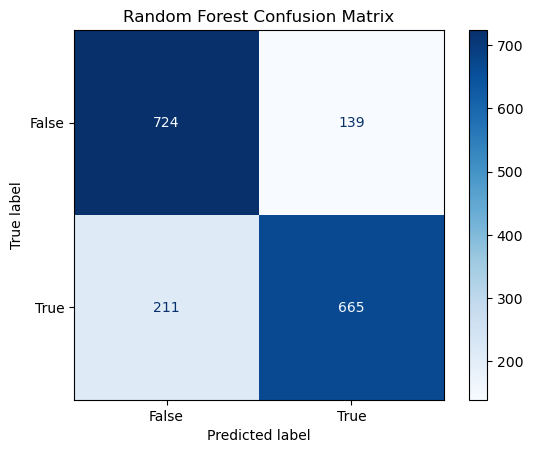

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create confusion matrix for plotting
disp1 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_a, y_pred_1),
                              display_labels=rf_model_1.classes_)

# Plot
disp1.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

We obtained similar results: the model is balanced and its overall performance is reasonable, although it seems to have more difficulty correctly predicting passengers who were actually transported. Lets check the feature importance:

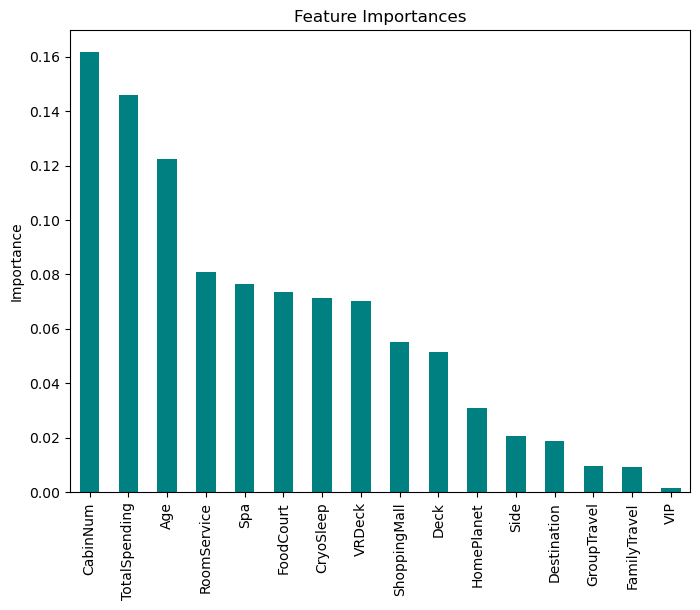

In [73]:
# Feature importances
importances = pd.Series(rf_model_1.feature_importances_, index=X_train_a.columns)
importances = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,6))
importances.plot(kind='bar', color='teal')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.show()

Cabin number appears to be important (not expected - weird!), together with TotalSpending and Age. On the other hand, VIP status and Family/group Travel are the features with less importance

### 1.1. Tuning the parameters

There are a lot of parameters that can be adjusted in a Random Forest model. Here, I will focus on some of them:
- **n_estimators:** Number of trees in the forest
- **max_depth:** Maximum number of levels for a decision tree - can prevent overfitting
- **min_samples_leaf:**  Minimum number of samples that is allowed in a tree leaf - allows more generalization.
- **max_features:** Maximum number of features considered for each split

In [34]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [50,100,150,200,300,500,700],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_leaf':[1,2,3,5,10],
    'max_features':['sqrt', 'log2']
}

gridforest = GridSearchCV(rf_model_1, parameters, cv=5, n_jobs=-1, verbose=1) #remember to adjust the number of CV
#CV number must be adjusted depending on the computer.
gridforest.fit(X_train_a, y_train_a)

print("Best parameters:", gridforest.best_params_)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 150}


In [37]:
# Initialize second model
rf_model_2 = RandomForestClassifier(random_state=42, max_depth=10, max_features='sqrt', min_samples_leaf=5,
                                    n_estimators=150)

# Fit model
rf_model_2.fit(X_train_a, y_train_a)

# Predict
y_pred_2 = rf_model_2.predict(X_test_a)

In [38]:
print("Accuracy:", round(accuracy_score(y_test_a, y_pred_2),3))
print("\nClassification Report:\n", classification_report(y_test_a, y_pred_2))

Accuracy: 0.799

Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.78      0.80       863
        True       0.79      0.81      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



Very similar

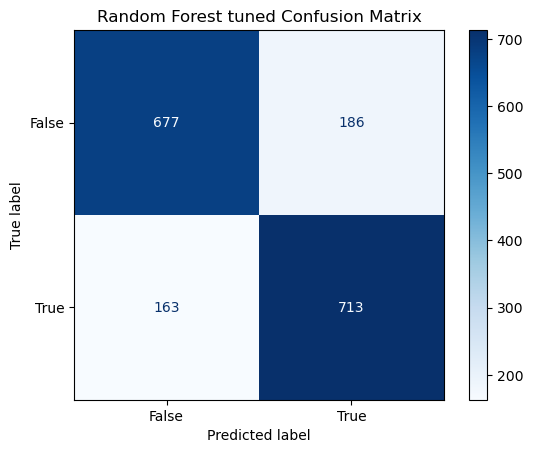

In [55]:
# Create confusion matrix for plotting
disp2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_a, y_pred_2),
                              display_labels=rf_model_2.classes_)

# Plot
disp2.plot(cmap='Blues')
plt.title("Random Forest tuned Confusion Matrix")
plt.show()

## 2. XGBoost models

XGBoost is an algorithm based on decision trees. While Random Forest models build trees independently, XGBoost uses gradient boosting, adding trees sequentially so that each new tree learns from the residual errors of the previous ones. This sequential correction improves accuracy. XGBoost also includes regularization to prevent overfitting.

Lets try it with our dataset:

In [43]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_a, y_train_a)

y_pred_xgb1 = xgb_model.predict(X_test_a)

In [44]:
print("Accuracy:", round(accuracy_score(y_test_a, y_pred_xgb1),3))
print("\nClassification Report:\n", classification_report(y_test_a, y_pred_xgb1))

Accuracy: 0.812

Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.81      0.81       863
        True       0.82      0.81      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



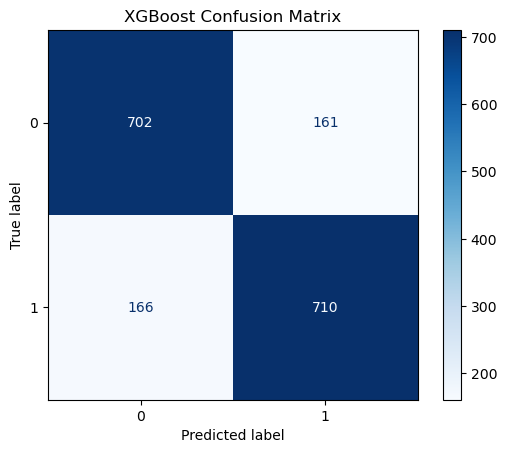

In [54]:
disp3 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_a, y_pred_xgb1),
                              display_labels=xgb_model.classes_)

# Plot
disp3.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

Better Accuracy than the Random Forest models, and it's more balanced! Now, we can check the feature importance, and compare it to the one that we got with Ranfom Forest:

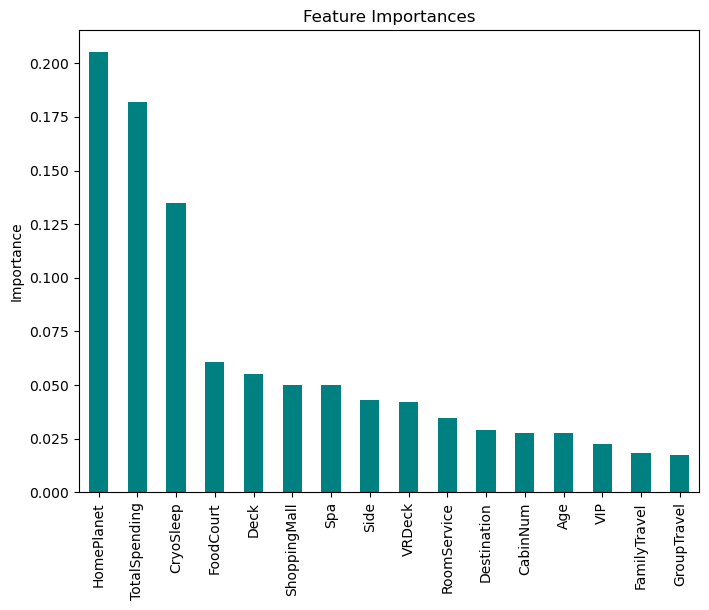

In [67]:
# Feature importances
importances = pd.Series(xgb_model.feature_importances_, index=X_train_a.columns)
importances = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,6))
importances.plot(kind='bar', color='teal')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.show()

Feature importance indicate that HomPlanet, TotalSpending and Cryosleep are the variables with higher importance (followed by FoodCourt and Deck). These results are somewhat different from those obtained using Random Forest models, and appear more coherent. On the other hand, FamilyTravel and GroupTravel have the least predictive power, which is consistent with the Random Forest results.


Lets tune the parameters and see if it improves. Information about the parameters of XGBoost can be found in here:
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning#3.-Basic-Setup-

- **Gamma:** Complexity cost by introducing additional leaf, goes from [0,infinite]. Gamma values around 20 are extremely high, and should be used only when you are using high depth. I will tune it only if needed.
https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6

- **max_depth:** maximum depth of a tree. Increasing = more likely to overfit. 

-  **min_child_weight:** minimum sum of weights of all observations required in a child (leaf). Higher values prevent overfitting - but also can lead to underfit. It has to be tuned. 

- **subsample:** XGBoost randomly sample part of the training data prior to growing trees. This will prevent overfitting. Tipically between 0.5-1.

- **eta [default=0.3, alias: learning_rate]:** step size shrinkage used in update to prevent overfitting. range : [0,1]. Typical final values : 0.01-0.2.


In [47]:
param_grid_xgb = {
    "n_estimators": [100,150,200,300,500,],
    "max_depth": [3, 5, 7, 10, None],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1],
    "min_child_weight": [0,1, 3,5]
}

In [48]:
gridforest_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, n_jobs=-1, verbose=1) #remember to adjust the number of CV
#CV number must be adjusted depending on the computer.
gridforest_xgb.fit(X_train_a, y_train_a)

print("Best parameters:", gridforest_xgb.best_params_)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.7}


In [50]:
xgb_model_2 = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    learning_rate= 0.05, 
    max_depth= 5, 
    min_child_weight= 3, 
    n_estimators= 200, 
    subsample= 0.7
)

xgb_model_2.fit(X_train_a, y_train_a)

y_pred_xgb2 = xgb_model_2.predict(X_test_a)

In [51]:
print("Accuracy:", round(accuracy_score(y_test_a, y_pred_xgb2),3))
print("\nClassification Report:\n", classification_report(y_test_a, y_pred_xgb2))

Accuracy: 0.813

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.80      0.81       863
        True       0.81      0.83      0.82       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



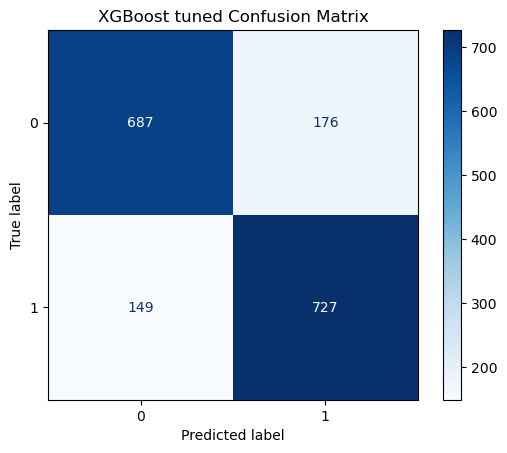

In [53]:
disp4 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_a, y_pred_xgb2),
                              display_labels=xgb_model_2.classes_)

# Plot
disp4.plot(cmap='Blues')
plt.title("XGBoost tuned Confusion Matrix")
plt.show()

The improvement is not very significant, but still there!

## 3. Ensemble models

Ensemble models combine multiple base models to improve predictive performance and reduce individual model biases. Here, I implemented a soft voting ensemble. In soft voting:

- Each model predicts the probability of each class.
- The class with the highest average probability is selected as the final prediction.

This approach leverages the strengths of different models while smoothing out individual errors.

In [74]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model_2),
        ('xgb', xgb_model_2),
    ],
    voting='soft',  # use 'soft' for probability averaging
    n_jobs=-1
)

voting_model.fit(X_train_a, y_train_a)

y_pred_ens = voting_model.predict(X_test_a)

In [75]:
print("Ensemble Accuracy:", accuracy_score(y_test_a, y_pred_ens))
print(classification_report(y_test_a, y_pred_ens))

Ensemble Accuracy: 0.8073605520414031
              precision    recall  f1-score   support

       False       0.82      0.79      0.80       863
        True       0.80      0.83      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



Results of the Ensemble model are in fact worst than our XGBoost model. This may happen for a combination of different reasons:
- Our models are highly correlated, and the type of error is similar. 
- The worst model (RF) "drags" the best model (XGBoost)

## 4. Final model (XGBoost) and predictions

I will use xgb_model_2 (tuned xgb model) for the final predictions: 

In [68]:
X_train_f = Train_Space.drop(["Transported", "PassengerId"], axis=1)
y_train_f = Train_Space["Transported"]

X_test_f = Test_Space.drop(["PassengerId"], axis=1)

In [71]:
#xgb_model = xgb.XGBClassifier(
#    objective='binary:logistic',
#    eval_metric='logloss',
#    random_state=42
#) 

xgb_model_2.fit(X_train_f, y_train_f)

y_pred_FINAL = xgb_model_2.predict(X_test_f)

In [72]:
submission = Test_Space[["PassengerId"]].copy()
submission["Transported"] = y_pred_FINAL
submission["Transported"] = submission["Transported"].astype(bool)  # ensure T/F

submission.to_csv("spaceship_titanic_submission_0825_2.csv", index=False)

And that would be the final submission ready to Kaggle! In this case, I got a final accuracy of **0.80173**

## 5. Final conclusions

**1. Modeling & Tuning**

- Random Forest and XGBoost models were trained and hyperparameter-tuned using GridSearchCV.
- XGBoost achieved the highest validation performance (~0.813), showing its strength for tabular, tree-based tasks.
- Soft voting ensembles were explored, but XGBoost alone performed slightly better due to its already strong predictions.

**2. Feature Importance**

- Feature importance plots for both Random Forest and XGBoost highlighted which variables drove the predictions. TOP features were different depending on the model 
- Features such as TotalSpending, CryoSleep, HomePlanet, and Cabin location (Deck) were among the most influential for the XGBoost model, demonstrating that the engineered features added predictive value. On the other hand, VIP status and Family/Group Travel were the least influential. 

🚀 **Portfolio Takeaways**

- The workflow demonstrates a clean, reproducible, end-to-end data science process: EDA → Imputation → Feature Engineering → Model Training → Evaluation → Submission.

- Attention to data preprocessing, feature design, and careful model evaluation is often more important than chasing marginal improvements in leaderboard scores.

**The final Kaggle submission achieved a score of 0.80173, showing that the approach generalizes well to unseen data**